In [51]:
import os
import sys

sys.path.append('../txf_design-space/')
sys.path.append('../txf_design-space/flexibert')
sys.path.append('../protran/boshnas/boshnas/')
sys.path.append('../global_search/utils')
sys.path.append('../')

import re
import yaml
import json
import time
import torch
import shlex
import shutil
import argparse
import subprocess
import collections
import numpy as np
from tqdm import tqdm, tqdm_notebook
from matplotlib import pyplot as plt

from embeddings.utils import graph_util, print_util as pu

sys.path.append('../txf_design-space/transformers/src/transformers')
import embedding_util

from boshnas import BOSHNAS
from acq import gosh_acq as acq

from transformers import BertModel
from transformers import RobertaTokenizer, RobertaModel
from transformers.models.bert.configuration_bert import BertConfig
from transformers.models.bert.modeling_modular_bert import BertModelModular, BertForMaskedLMModular, BertForSequenceClassificationModular

import warnings
warnings.filterwarnings("ignore")

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

from six.moves import cPickle as pickle
from scipy.interpolate import griddata
from sklearn.tree import plot_tree
from scipy.optimize import minimize, differential_evolution

PREFIX_CHECKPOINT_DIR = "checkpoint"

MODEL					TYPE		PARAMS		ITERATIONS	LOSS
f36d5c40c770e4f787c78b43a2a09d78	shallow_narrow	70.20M		1000000		2.4507
e3ea4dd7dab98b7ca6aa439a22e2c669	deep_narrow	111.66M		1000000		3.2495
cc085bb5b433b6808e32bd7d1ff49584	deep_narrow	103.37M		937000		2.1995
bec578218d4f893fdd754d7497af18d5	deep_narrow	81.76M		414500		7.6943
2a8863139d4ccf931452c5f86c3a5a52	shallow_narrow	37.40M		1000000		3.0133
1d41e1cdd47ac30c570648bcddd22ad1	shallow_narrow	36.56M		1000000		7.6902
49ef529d1cada10c9b92463e129424d4	deep_narrow	74.44M		907000		2.6352
cbf26e711763f177f534ad38b8c7b8a7	shallow_narrow	63.28M		135500		7.6907
dc7733ef95c734eee308504f5e0a384e	shallow_wide	69.57M		348500		2.9617
89ca0068830d26fdebfbc79a501b5f2a	deep_wide	110.78M		-		nan
fb76fc6b9cdde469653ce1d3f163b542	deep_wide	102.34M		242000		2.67
fb04cff166ed53cb40500c78626889ea	deep_wide	80.72M		182500		7.6942
7cf1bfa8946458f7f6d261b11a9166bf	shallow_wide	37.17M		-		nan
081cb16979c43ce0b68a45650dc2de84	shallow_wide	35.12M		350500		2.9191
ae87fe8c1

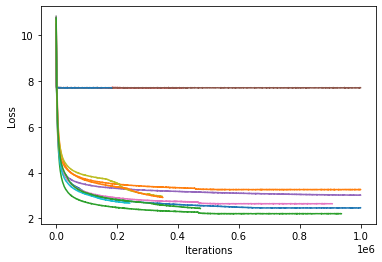

In [37]:
# Get Sobol samples and training status
glob_dataset_file = '../global_search/dataset/dataset.json'
models_dir = '../models/global_search/'

tokenizer = RobertaTokenizer.from_pretrained('../txf_design-space/roberta_tokenizer/')
config = BertConfig(vocab_size = tokenizer.vocab_size)

dataset = json.load(open(glob_dataset_file, 'r'))

X_list, y_list = [], []

print('MODEL\t\t\t\t\tTYPE\t\tPARAMS\t\tITERATIONS\tLOSS')
for model in dataset.keys():
    model_dir = os.path.join(models_dir, model)
    
    # Get the number of model parameters
    config = BertConfig(vocab_size = tokenizer.vocab_size)
    config.from_model_dict_hetero(dataset[model]['model_dict'])
    flexibert_model = BertModelModular(config)
    model_params = pu.human_format(sum(p.numel() for p in flexibert_model.parameters() if p.requires_grad))
    
    # Find the latest checkpoint for chosen model
    re_checkpoint = re.compile(r"^" + PREFIX_CHECKPOINT_DIR + r"\-(\d+)$")
    content = os.listdir(model_dir)
    checkpoints = [
            path
            for path in content
            if re_checkpoint.search(path) is not None and os.path.isdir(os.path.join(model_dir, path))]
    
    # Get latest checkpoint
    if len(checkpoints) > 0:
        checkpoint_dir = max(checkpoints, key=lambda x: int(re_checkpoint.search(x).groups()[0]))
        latest_checkpoint = int(checkpoint_dir.split('-')[1])
        trainer_state = json.load(open(os.path.join(model_dir, checkpoint_dir, 'trainer_state.json')))
        
        # Get pretraining loss
        pretrain_loss = min([state['loss'] for state in trainer_state['log_history']])
        
        # Plot loss curve
        plt.plot([state['step'] for state in trainer_state['log_history']], 
                 [state['loss'] for state in trainer_state['log_history']], label=model)
        
        X_list.append(eval(dataset[model]['embedding'])); y_list.append(pretrain_loss)
    else:
        latest_checkpoint = '-'
        pretrain_loss = np.nan
        
    print(f'{model}\t{dataset[model]["model_type"]}\t{model_params}\t\t{latest_checkpoint}\t\t{pretrain_loss}')

# plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [54]:
# Test MSE for different regressors on the dataset
regressors = ['LR', 'GP', 'DT', 'BDT', 'BOSHNAS']

# Load design space
design_space = yaml.safe_load(open('../global_search/design_space/design_space.yaml'))

X, y = np.array(X_list), np.array(y_list)
X_train, y_train = X[:9, :], y[:9]
X_test, y_test = X[9:, :], y[9:]

for regressor in regressors:
    if regressor == 'BOSHNAS':
        embedding_dim = X_train.shape[1]
        embedding_bounds = embedding_util.get_embedding_bounds(design_space, 'all')
        embedding_bounds = (np.array([bound[0] for bound in embedding_bounds]), np.array([bound[1] for bound in embedding_bounds]))

        model = BOSHNAS(input_dim=embedding_dim,
            bounds=embedding_bounds,
            trust_region=False,
            second_order=True,
            parallel=True,
            model_aleatoric=False,
            save_path='./surrogate_models_test',
            pretrained=False)
        
        model.train(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = np.array([pred[0].item() for pred in y_pred])
    elif regressor == 'LR':
        lm = Ridge(alpha=0.5)
        lm.fit(X_train, y_train)
        y_pred = lm.predict(X_test)
    elif regressor == 'GP':
        gpr = GaussianProcessRegressor(random_state=0)
        gpr.fit(X_train, y_train)
        y_pred = gpr.predict(X_test)
    elif regressor == 'DT':
        dtr = DecisionTreeRegressor(random_state=0)
        dtr.fit(X_train, y_train)
        y_pred = dtr.predict(X_test)
    elif regressor == 'BDT':
        bdtr = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators=50)
        bdtr.fit(X_train, y_train)
        y_pred = bdtr.predict(X_test)
    print(f'Test MSE for {regressor}:\t{mean_squared_error(y_test, y_pred): 0.2f}')

Test MSE for LR:	 27866.71
Test MSE for GP:	 20.20
Test MSE for DT:	 7.73
Test MSE for BDT:	 6.93
Test MSE for BOSHNAS:	 13.34


In [ ]:
# Test ranking performance of different regressors on the dataset